In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#from modules.dataloader import get_loaders
from modules.dali_dataloader import get_loader
import torch
import matplotlib.pyplot as plt
from modules.optimizers import optimizer_factory
from modules.lrfinder import LRFinder
from torchvision import models

In [5]:
model = models.mobilenet_v2().cuda(1)
loader = get_loader(224, 64, 4, 1, True)

In [6]:
len(loader)

20018

In [13]:
#optim = torch.optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=1e-5)
optim = optimizer_factory('sgdw')(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=1e-5)
loss = torch.nn.CrossEntropyLoss()

In [18]:
lrfinder = LRFinder(model, optim, loss)
lrfinder.range_test(loader, num_iter=250, end_lr=2)


Learning rate search finished. See the graph with {finder_name}.plot()


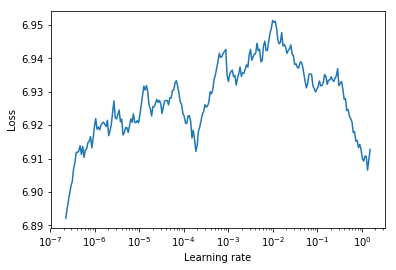

In [19]:
lrfinder.plot()

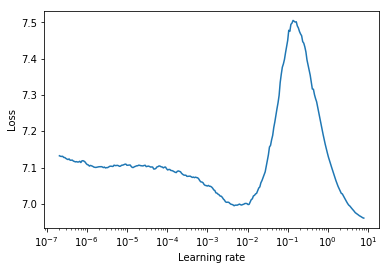

In [27]:
# basic SGD 
lrfinder.plot()

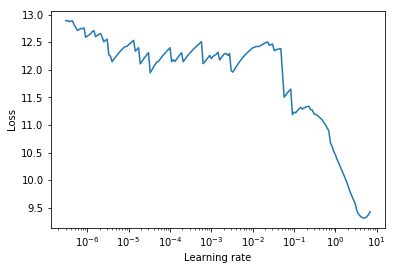

In [17]:
lrfinder.plot()

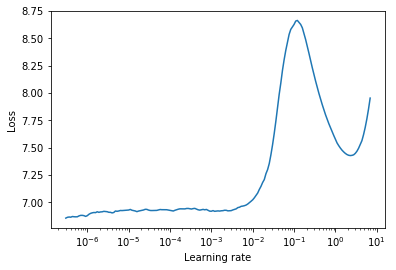

In [15]:
lrfinder.plot()

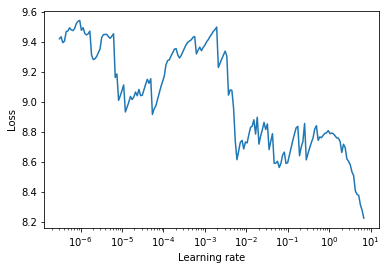

In [11]:
lrfinder.plot()

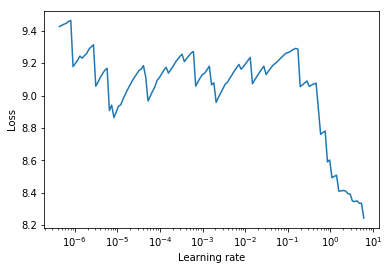

In [9]:
lrfinder.plot()

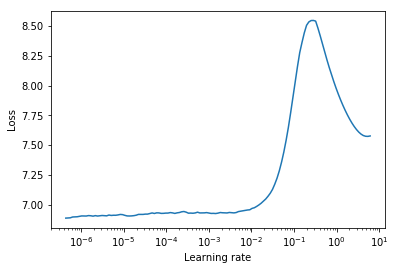

In [36]:
lrfinder.plot()